## Testing hypothesis 2
---

**_Hypothesis_**: Reviews with more positive sentiment words receive higher helpfulness ratings.

- **Metric**: Mean helpfulness ratings for number of positive and negative words.

- **Model**: Multinomial Naive Bayes.

- **Description**:

  - Use NBC as a classifier to predict the sentiment of a review.
  - Extract the most useful words from the classifier.
  - Compute the mean helpfulness ratings for the most useful words.  

**Missing Values**:

  - `review/score`: remove the entire sample
  - `review/text`: remove the entire sample
  - `review/helpfulness`: remove the entire sample

**Data Transformation**:

  - `review/score`: Assign 1 to score (4, 5), 0 to score (1, 2). 
  - `review/text`: Create the BoW for the text. Fit a MNBC and count the number of positive and negative words. Graphical Plot.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [9]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['book_reviews']

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Remove the samples if the fields reported above have missing values. Remove also the samples with score equal to 3, since it indicates a neutral review.
pipeline_remove = {'$match':
                            {
                            'review/text':{'$exists':True},
                            'review/score':{'$exists':True, '$ne':3},
                            'Tot_votes'	:{'$exists':True, '$ne':0}
                            }
                }

# Create a new field called class. If the score is greater than 3, the class is 1, otherwise is 0.
pipeline_class = {'$project':{
                        '_id':0,
                        'review/text':1,
                        'review/helpfulness_rate': {'$multiply': [
                            {'$divide': ['$N_helpful', '$Tot_votes']},
                            {'$sqrt': '$Tot_votes'}
                        ]
                        },
                        'class':{
                            '$cond':{
                                'if':{'$in':['$review/score', [4,5]]},
                                'then':1,
                                'else':0
                            }
                        }
                    }
                }

books_removed = books.aggregate([pipeline_remove, pipeline_class])
df = pd.DataFrame(list(books_removed))

In [11]:
# # Remove punctuation and convert to lowercase the review/text column
df['review/text'] = df['review/text'].replace('[^\w\s]', ' ', regex=True)
df['review/text'] = df['review/text'].str.lower()
df.head()

# # Remove stopwords from the review/text column
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
df['review/text'] = df['review/text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

# # Remove words with length less than 2 from the review/text column
df['review/text'] = df['review/text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
df.head()

[nltk_data] Downloading package stopwords to /home/hdoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review/text,review/helpfulness_rate,class
0,self published book want know read paragraphs ...,0.707107,0
1,read review directly mine say laughed someone ...,1.666667,1
2,useful thorough text book would recommend anyo...,1.341641,1
3,thoroughly enjoyed rising sons daughters know ...,1.000000,1
4,sorry mistake could english first language dra...,2.236068,1


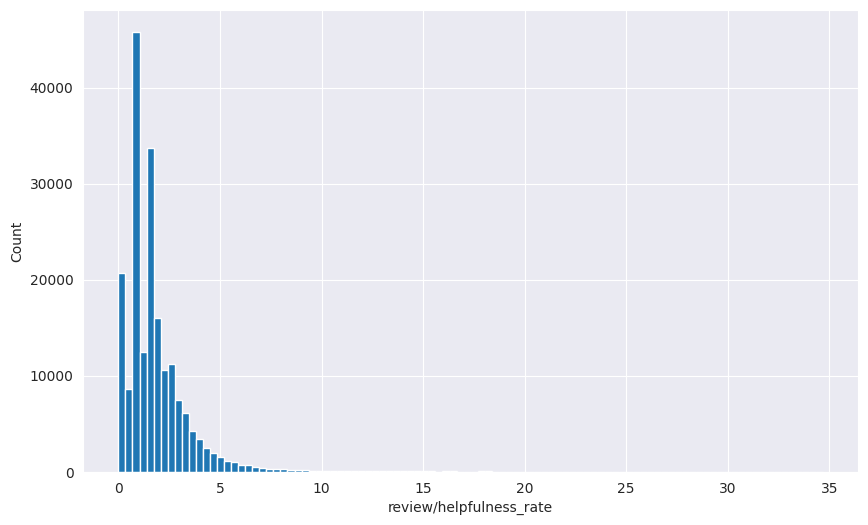

In [12]:
# # Plot the histogram of the helpful_score
plt.figure(figsize=(10, 6))
plt.hist(df['review/helpfulness_rate'], bins=100)
plt.xlabel('review/helpfulness_rate')
plt.ylabel('Count')
plt.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# dictionary of 2000 words
# # Build a bag of words
vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['review/text'])
y = df['class']

# # Train a Naive Bayes classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [14]:
# # Print the most 20 positive words
feature_names = vectorizer.get_feature_names_out()
pos_neg_ratio = nb.feature_log_prob_[1, :] - nb.feature_log_prob_[0, :]
pos_neg_ratio_sorted = np.argsort(pos_neg_ratio)
print("Most 20 positive words:")
for i in pos_neg_ratio_sorted[-20:]:
    print(feature_names[i], pos_neg_ratio[i])

# # Print the most 20 negative words
print("Most 20 negative words:")
for i in pos_neg_ratio_sorted[:20]:
    print(feature_names[i], pos_neg_ratio[i])

Most 20 positive words:
excellent 1.2651095766927654
outstanding 1.282569431176075
touching 1.3032191324666194
vivid 1.3604772424252118
challenges 1.374112801280761
darcy 1.382020263108675
accessible 1.3971636227808482
favorites 1.4024346330367852
resource 1.4152521367474016
struggles 1.4431926255089529
beautifully 1.4458771908796226
remarkable 1.5206163879928596
delight 1.5589210444564099
refreshing 1.5800177082108018
wonderfully 1.5976977267469739
delightful 1.8176300257875262
timeless 1.8746921306682598
captures 1.9008062524376221
explores 1.980947661153575
bilbo 2.328913291298429
Most 20 negative words:
waste -2.7315015673063057
poorly -2.6444393165598923
disappointment -1.9799730272330152
boring -1.9636602400655052
worst -1.8873831102948282
stupid -1.793045640983185
ridiculous -1.718556828951887
annoying -1.674431295277694
dull -1.5672423523768844
flat -1.5586845226756765
fails -1.5104086006882405
errors -1.5098644200068305
jordan -1.4879401494386233
hoping -1.4561506422423491
dis

Plot with 800 most positive words:
Correlation Coefficient: 0.2246140667473128
P-value: 0.0



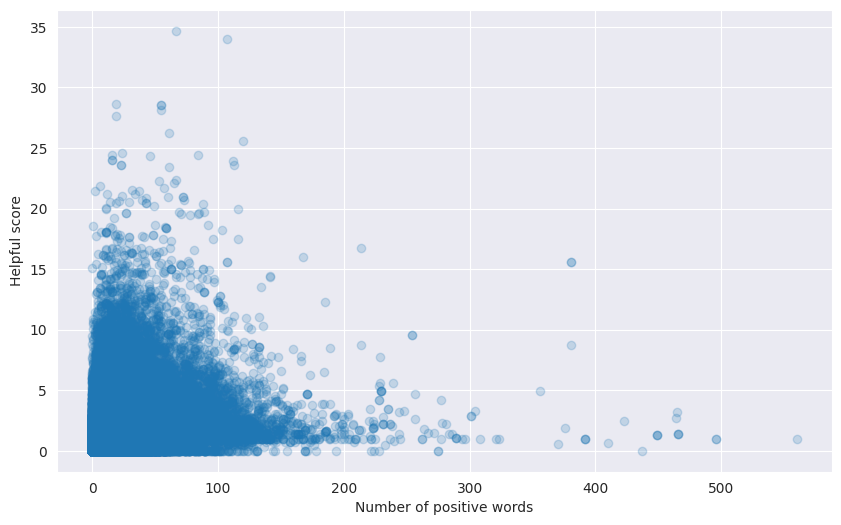

/home/hdoop/.virtualenvs/PyProject/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hdoop/.virtualenvs/PyProject/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Group number: 10
Correlation Coefficient: 0.16323476967604467
P-value: 0.0



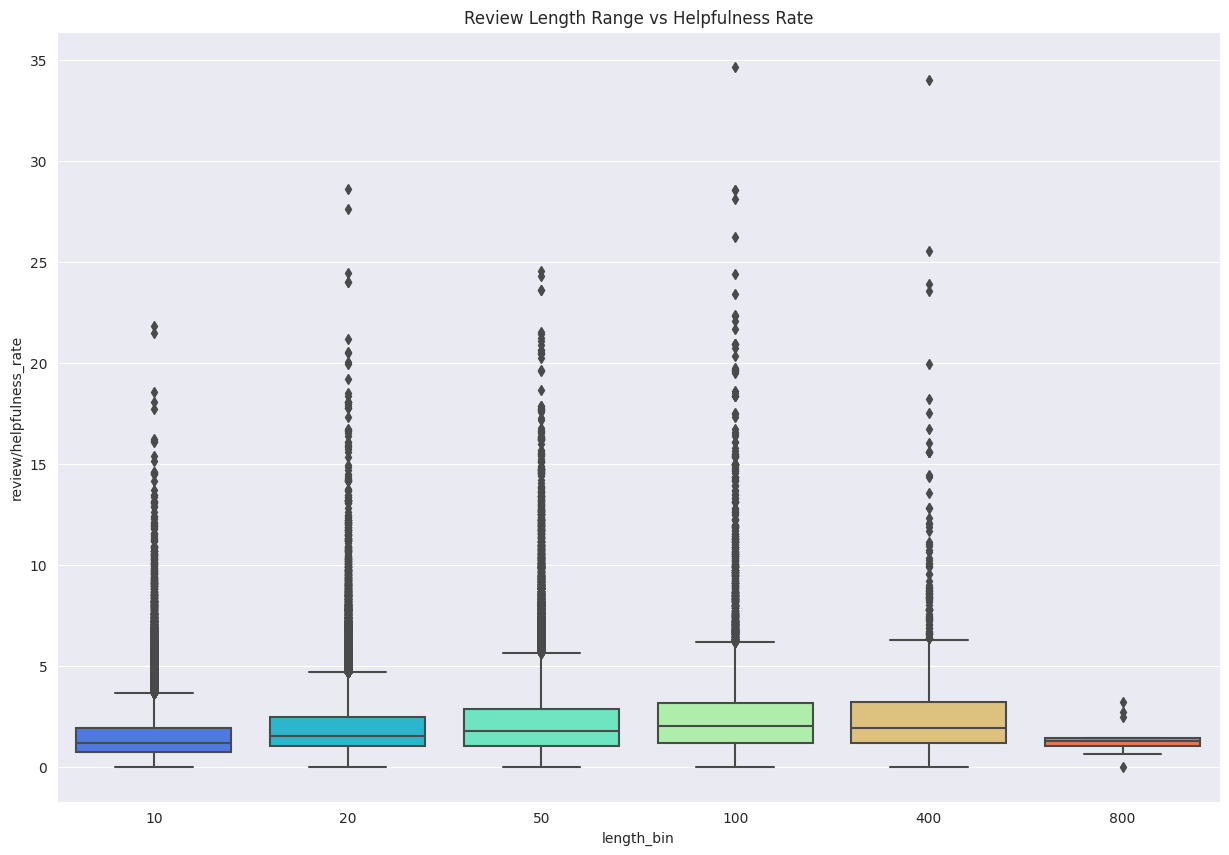

<Figure size 1500x1000 with 0 Axes>

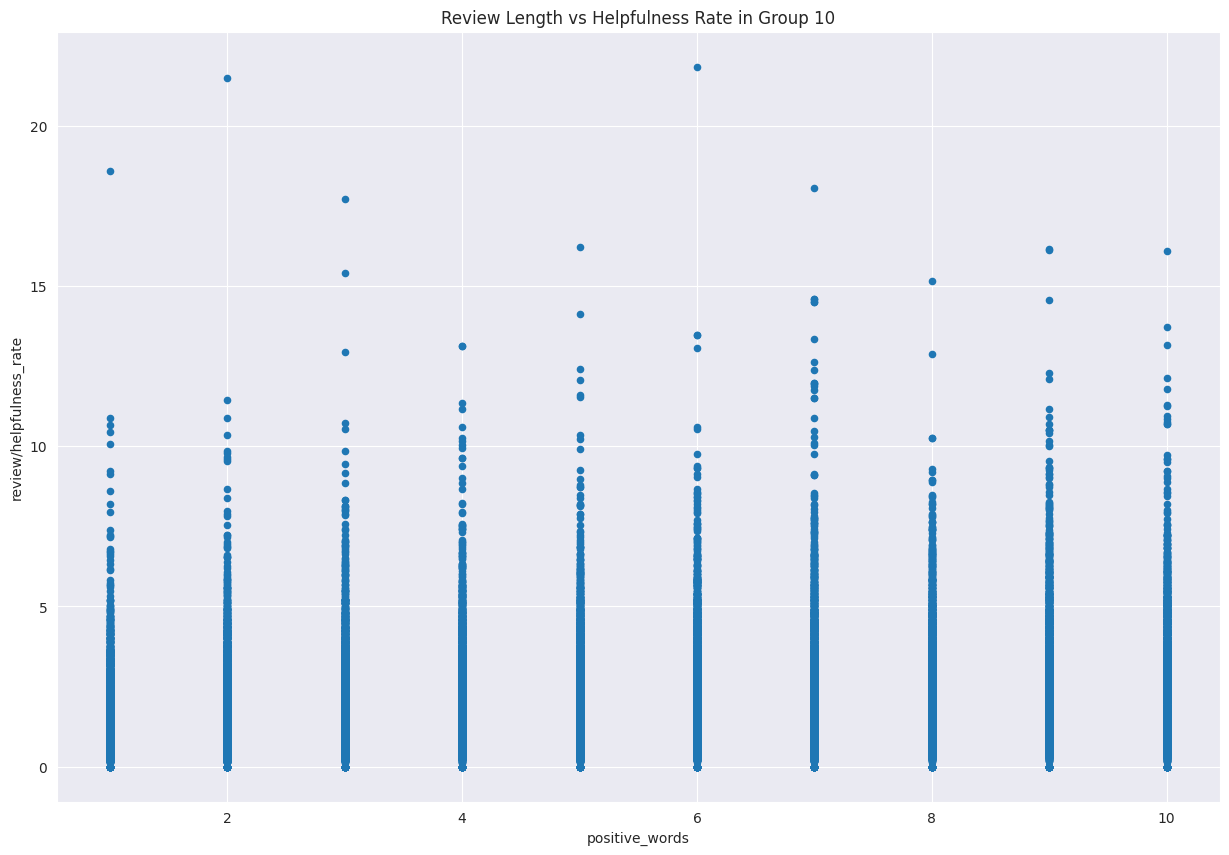

Group number: 20
Correlation Coefficient: 0.045778176199059814
P-value: 2.3438980924605815e-44



<Figure size 1500x1000 with 0 Axes>

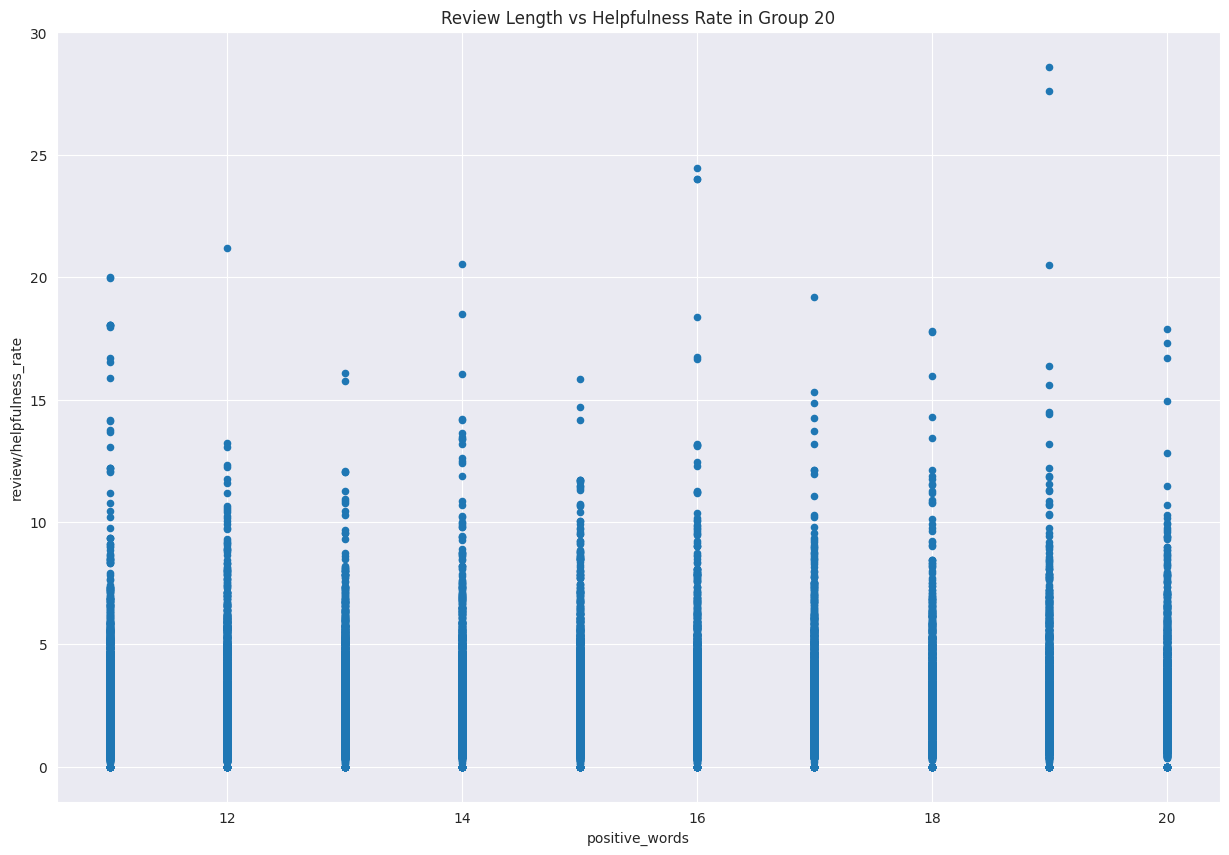

Group number: 50
Correlation Coefficient: 0.033596963492221174
P-value: 2.089491650468228e-21



<Figure size 1500x1000 with 0 Axes>

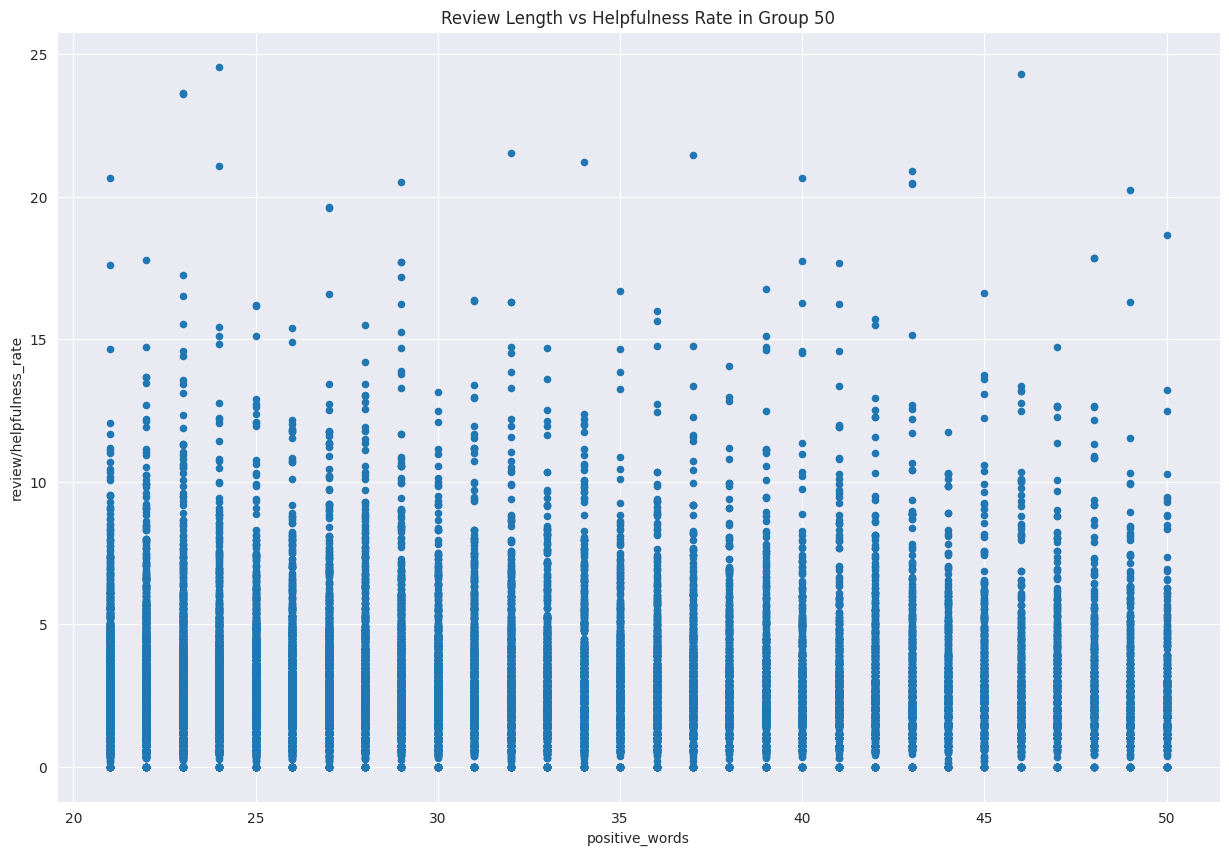

Group number: 100
Correlation Coefficient: 0.020837689625666057
P-value: 0.0038469639668753373



<Figure size 1500x1000 with 0 Axes>

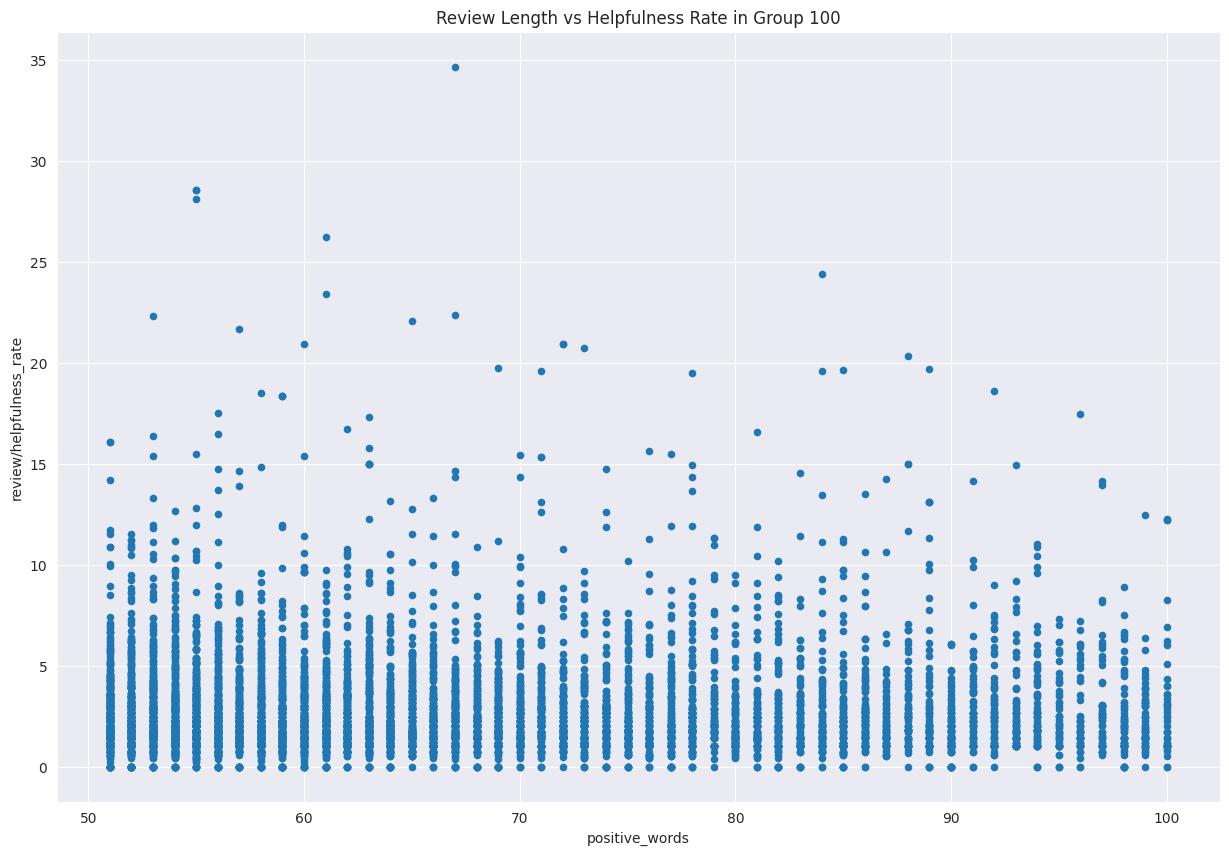

Group number: 400
Correlation Coefficient: -0.038606063337109156
P-value: 0.04087970882615489



<Figure size 1500x1000 with 0 Axes>

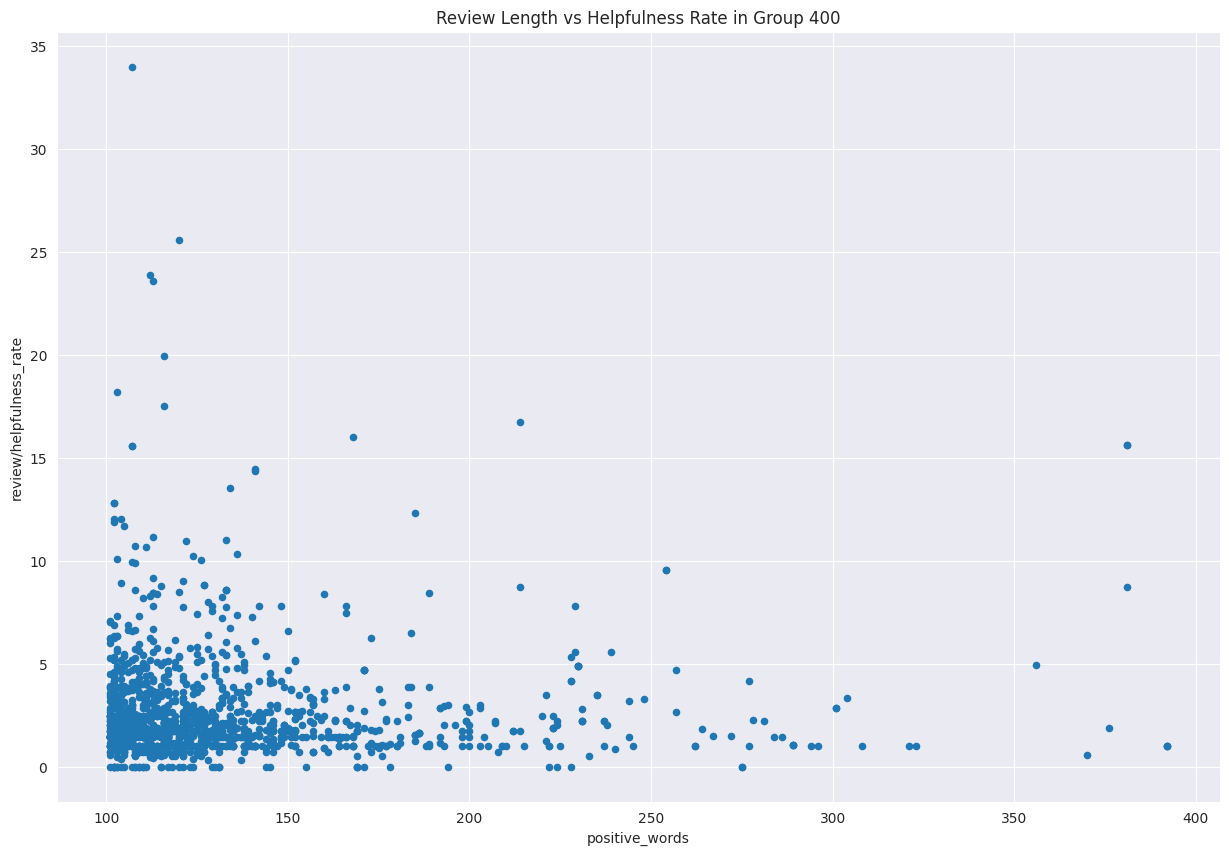

Group number: 800
Correlation Coefficient: 0.0
P-value: 1.0



<Figure size 1500x1000 with 0 Axes>

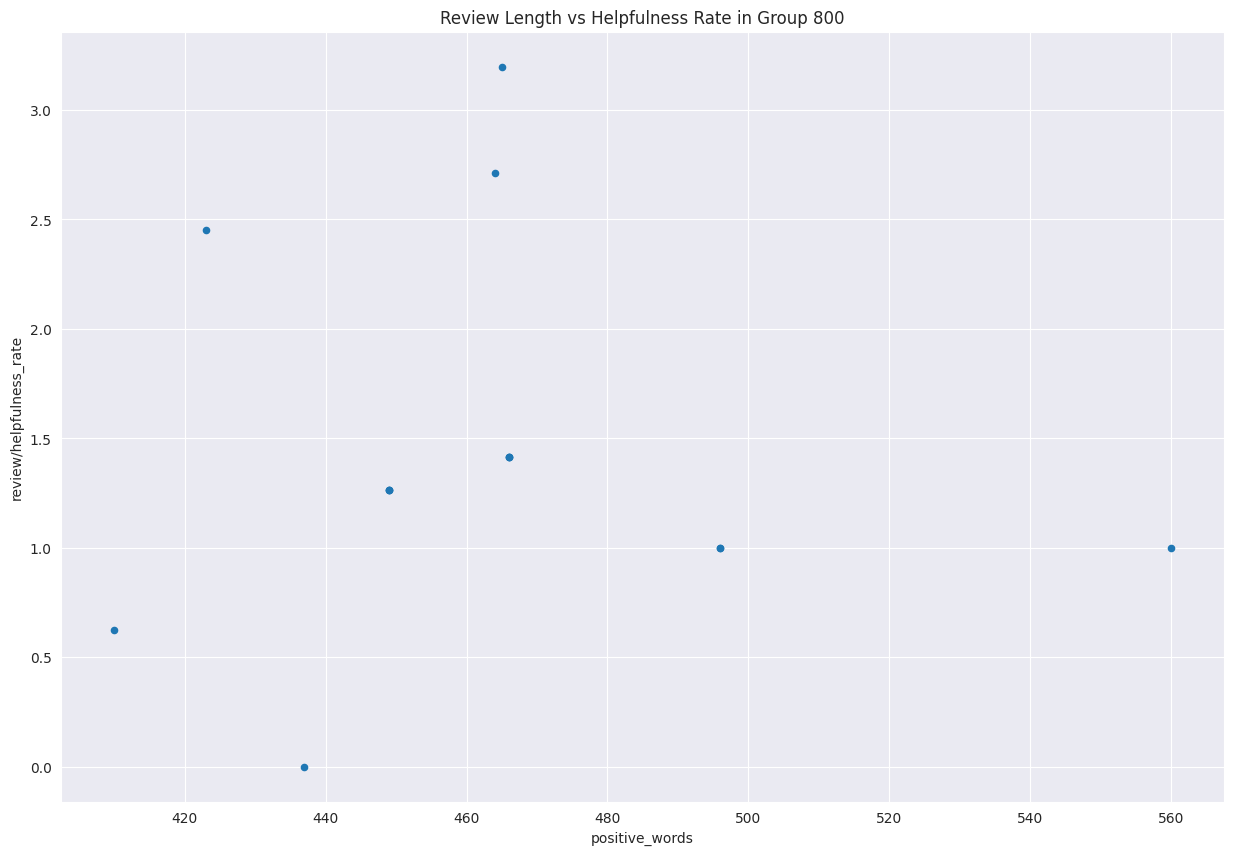

In [15]:
import scipy
import seaborn as sns
import scipy.stats as stats

for N in {800}:
    # # Create a new column with the number of positive words in the review/text column
    print(f"Plot with {N} most positive words:")
    df['positive_words'] = df['review/text'].apply(lambda x: len([word for word in x.split() if word in feature_names[pos_neg_ratio_sorted[-N:]]]))
    df.head()

    corr, pval = stats.kendalltau(df['positive_words'], df['review/helpfulness_rate'])
    print(f'Correlation Coefficient: {corr}\nP-value: {pval}\n')

    # # Plot the helpful_score vs the number of positive words in the review/text column
    plt.figure(figsize=(10, 6))
    plt.scatter(df['positive_words'], df['review/helpfulness_rate'], alpha=0.2)
    plt.xlabel('Number of positive words')
    plt.ylabel('Helpful score')
    plt.show()

    # Create 5 bins of positive_words
    groups = [0, 10, 20, 50, 100, 400, 800]
    df['length_bin'] = pd.cut(df['positive_words'], bins=groups, labels=[group for group in groups[1:]])

    # Plot the distribution of positive_words with respect to helpfulness rate
    plt.figure(figsize=(15, 10))
    sns.boxplot(x='length_bin', y='review/helpfulness_rate', data=df, palette='rainbow')
    plt.title('Review Length Range vs Helpfulness Rate')

    for el in groups[1:]:
        dataframe = df[df['length_bin'] == el]
        corr, pval = scipy.stats.kendalltau(dataframe['positive_words'], dataframe['review/helpfulness_rate'])
        print(f'Group number: {el}\nCorrelation Coefficient: {corr}\nP-value: {pval}\n')
        plt.figure(figsize=(15, 10))
        dataframe.plot(kind='scatter', x='positive_words', y='review/helpfulness_rate', figsize=(15, 10), title=f'Review Length vs Helpfulness Rate in Group {el}')
        plt.show()



In [16]:
client.close()